## Monte Carlo simulation with fixed investment rate
Static approach being simple but significantly worse than dynamic investment rate setting, blah blah blah

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_seed(42)

capital_per_turn = []
data = []
simulation_num = 10000
percentage_to_bet = 0.23
loss_counter = 0

for k in range(simulation_num):
    capital = 100
    turn_num = 0
    
    for x in range(100):
        if capital == 0:
            loss_counter += 1
            break        

        turn_num += 1

        randint = random.randint(1, 10)

        if randint >= 5:  # Win (60%)
            capital *= (1 + percentage_to_bet)
        else:  # Lose (40%)
            capital *= (1 - percentage_to_bet)
        
        capital_per_turn.append(capital)
    data.append(capital_per_turn[-1])

df = pd.DataFrame(data)

Loss counter: 0
                  0
count  1.000000e+04
mean   8.680529e+03
std    4.881285e+04
min    2.392320e-02
25%    1.752639e+02
50%    7.143905e+02
75%    2.911916e+03
max    2.051069e+06


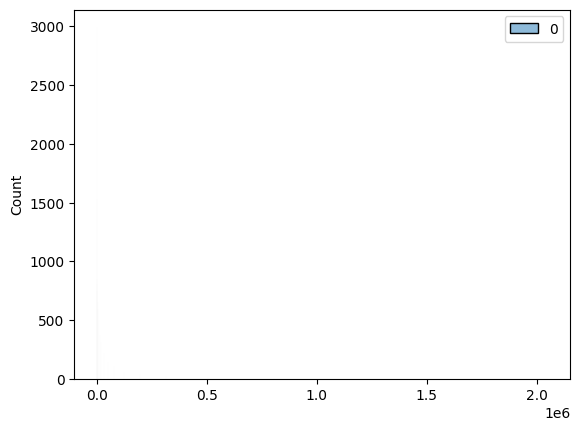

In [4]:
print(f"Loss counter: {loss_counter}")
print(df.describe())

# print(df.info())
sns.histplot(df)

plt.show()

## Reinforced Learning approach
Dynamic approach better than static, blah blah blah

In [5]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt

In [6]:
import gymnasium as gym
from gymnasium import spaces


class InvestmentEnv(gym.Env):
    """
    Custom Gymnasium environment for the investment game.
    
    State Space:
        - Current capital (continuous)
        - Current round number (0-99)
    
    Action Space:
        - Investment percentage (continuous, 0.0 to 1.0)
    
    Rewards:
        - Based on capital change each round
    """
    
    def __init__(self, initial_capital=100, num_rounds=100, win_probability=0.6):
        super(InvestmentEnv, self).__init__()
        
        # Game parameters
        self.initial_capital = initial_capital
        self.num_rounds = num_rounds
        self.win_probability = win_probability
        
        # Define action space: investment percentage between 0% and 100%
        self.action_space = spaces.Box(
            low=0.0, 
            high=1.0, 
            shape=(1,), 
            dtype=np.float32
        )
        
        # Define observation space: [capital, round_number]
        # Capital can theoretically grow unbounded, but we'll set a reasonable upper limit
        self.observation_space = spaces.Box(
            low=np.array([0, 0], dtype=np.float32),
            high=np.array([1e10, num_rounds], dtype=np.float32),
            dtype=np.float32
        )
        
        # Initialise state
        self.capital = None
        self.current_round = None
        self.np_random = None
        
    def reset(self, seed=None, options=None):
        """
        Reset the environment to initial state.
        Called at the start of each episode.
        """
        super().reset(seed=seed)
        
        self.capital = float(self.initial_capital)
        self.current_round = 0
        
        observation = self._get_observation()
        info = {}
        
        return observation, info
    
    def step(self, action):
        """Execute one round of the game."""
        old_capital = self.capital
        
        investment_percentage = np.clip(action[0], 0.0, 1.0)
        investment_amount = self.capital * investment_percentage
        
        outcome = self.np_random.random()
        
        if outcome < self.win_probability:
            self.capital += investment_amount
        else:
            self.capital -= investment_amount
        
        if self.capital < 0:
            self.capital = 0
        
        self.current_round += 1
        terminated = (self.current_round >= self.num_rounds) or (self.capital == 0)
        truncated = False
        
        # REWARD WITH STAGNANCY PENALTY
        if terminated:
            if self.capital > 0:
                # Reward based on total growth
                reward = np.log(self.capital / self.initial_capital) * 10
            else:
                reward = -50  # Bankruptcy penalty
        else:
            # Intermediate reward
            capital_change = self.capital - old_capital
            reward = capital_change / self.initial_capital
            
            # STAGNANCY PENALTY: Punish low investment percentages
            if investment_percentage < 0.05:  # Less than 5% investment
                reward -= 0.5  # Penalty for being too conservative
            
            # BONUS: Reward for taking reasonable risks
            if 0.15 <= investment_percentage <= 0.40:
                reward += 0.1  # Small bonus for "reasonable" investment range
        
        observation = self._get_observation()
        info = {
            'capital': self.capital,
            'round': self.current_round,
            'investment_percentage': investment_percentage,
            'won': outcome < self.win_probability
        }
        
        return observation, reward, terminated, truncated, info
    
    def _get_observation(self):
        """Return the current state observation."""
        return np.array([self.capital, self.current_round], dtype=np.float32)
    
    def render(self):
        """Optional: print current state (useful for debugging)."""
        print(f"Round {self.current_round}/{self.num_rounds} | Capital: ${self.capital:.2f}")

In [7]:
# Create environment
env = InvestmentEnv()

# Test one episode with random actions
observation, info = env.reset(seed=42)
print(f"Initial state: Capital=${observation[0]:.2f}, Round={observation[1]}")

for i in range(5):  # Just test 5 rounds
    # Random action (random investment percentage)
    action = env.action_space.sample()
    
    observation, reward, terminated, truncated, info = env.step(action)
    
    print(f"Round {info['round']}: Invested {info['investment_percentage']*100:.1f}% | "
          f"{'WON' if info['won'] else 'LOST'} | Capital: ${info['capital']:.2f}")
    
    if terminated:
        print("Episode ended!")
        break

env.close()

Initial state: Capital=$100.00, Round=0.0
Round 1: Invested 47.7% | LOST | Capital: $52.26
Round 2: Invested 71.6% | WON | Capital: $89.68
Round 3: Invested 10.0% | LOST | Capital: $80.74
Round 4: Invested 22.4% | LOST | Capital: $62.66
Round 5: Invested 53.9% | WON | Capital: $96.43


## RL Model Training

In [8]:
timestamp = datetime.now().strftime("%d-%m_%H-%M")

# Create vectorised environment (runs multiple envs in parallel for faster training)
env = make_vec_env(InvestmentEnv, n_envs=4)

# Create evaluation environment (for monitoring progress)
eval_env = InvestmentEnv()

# Set up evaluation callback (checks performance during training)
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=10000,  # Evaluate every 10k steps
    deterministic=True,
    render=False,
    n_eval_episodes=100  # Run 100 episodes for evaluation
)

# Initialise PPO agent
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    ent_coef=0.01,  # Encourages exploration - fixes "sparse reward + poor exploration problem"
    tensorboard_log="./ppo_investment_tensorboard/"
)

print("Starting training...")
print("=" * 50)

# Train the agent
model.learn(
    total_timesteps=500000,  # Total training steps (adjust if needed)
    callback=eval_callback,
    progress_bar=True
)

# Save the trained model
model.save(f"ppo_investment_agent_{timestamp}")
print(f"\nTraining complete! Model saved as 'ppo_investment_agent_{timestamp}'")

Using cpu device
Starting training...
Logging to ./ppo_investment_tensorboard/PPO_4


a:\Repositories\Investing-simulation\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 237      |
| time/              |          |
|    fps             | 2003     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20.8         |
|    ep_rew_mean          | 24.9         |
| time/                   |              |
|    fps                  | 542          |
|    iterations           | 2            |
|    time_elapsed         | 30           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0045879893 |
|    clip_fraction        | 0.0306       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 1.47e-05     |
|    learning_r

a:\Repositories\Investing-simulation\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=40000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.0015964541 |
|    clip_fraction        | 0.000647     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.00892      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.19e+03     |
|    n_updates            | 40           |
|    policy_gradient_loss | 0.000111     |
|    std                  | 0.973        |
|    value_loss           | 6.56e+04     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | -40.2    |
| time/              |          |
|    fps             | 336      |
|    iterations      | 5        |
|    time_elapsed    | 121      |
|    total_timesteps | 40960    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 33.6         |
|    ep_rew_mean          | -48.2        |
| time/                   |              |
|    fps                  | 337          |
|    iterations           | 6            |
|    time_elapsed         | 145          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0032600902 |
|    clip_fraction        | 0.0317       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.0122       |
|    learning_r

Eval num_timesteps=80000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -49.5       |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.004123073 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.0142      |
|    learning_rate        | 0.0003      |
|    loss                 | 96.6        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0015     |
|    std                  | 0.884       |
|    value_loss           | 332         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 56.3     |
|    ep_rew_mean     | -17.4    |
| time/              |          |
|    fps             | 325      

Eval num_timesteps=120000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -49.5       |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.001183343 |
|    clip_fraction        | 0.0148      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.000515   |
|    std                  | 0.822       |
|    value_loss           | 70          |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81       |
|    ep_rew_mean     | -29      |
| time/              |          |
|    fps             | 308      

Eval num_timesteps=160000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0024437753 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.4         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00171     |
|    std                  | 0.835        |
|    value_loss           | 42           |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 71.7     |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    fps     

Eval num_timesteps=200000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0032046065 |
|    clip_fraction        | 0.029        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.822        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.000815    |
|    std                  | 0.782        |
|    value_loss           | 24.2         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.5     |
|    ep_rew_mean     | -50.1    |
| time/              |          |
|    fps     

Eval num_timesteps=240000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 240000       |
| train/                  |              |
|    approx_kl            | 0.0028695476 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.894        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.6         |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000265    |
|    std                  | 0.767        |
|    value_loss           | 16.2         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.5     |
|    ep_rew_mean     | -48.5    |
| time/              |          |
|    fps     

Eval num_timesteps=280000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 280000       |
| train/                  |              |
|    approx_kl            | 0.0034348504 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | 0.818        |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00113     |
|    std                  | 0.748        |
|    value_loss           | 24.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.9     |
|    ep_rew_mean     | -51.4    |
| time/              |          |
|    fps     

Eval num_timesteps=320000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -49.5       |
| time/                   |             |
|    total_timesteps      | 320000      |
| train/                  |             |
|    approx_kl            | 0.004010042 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.68        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.000307   |
|    std                  | 0.72        |
|    value_loss           | 19          |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.9     |
|    ep_rew_mean     | -52.9    |
| time/              |          |
|    fps             | 393      

Eval num_timesteps=360000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 360000       |
| train/                  |              |
|    approx_kl            | 0.0026812013 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | 0.88         |
|    learning_rate        | 0.0003       |
|    loss                 | 5.8          |
|    n_updates            | 430          |
|    policy_gradient_loss | -7.84e-05    |
|    std                  | 0.709        |
|    value_loss           | 15.6         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.2     |
|    ep_rew_mean     | -47.5    |
| time/              |          |
|    fps     

Eval num_timesteps=400000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 400000       |
| train/                  |              |
|    approx_kl            | 0.0032702032 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.04        |
|    explained_variance   | 0.89         |
|    learning_rate        | 0.0003       |
|    loss                 | 6.85         |
|    n_updates            | 480          |
|    policy_gradient_loss | 0.000794     |
|    std                  | 0.681        |
|    value_loss           | 16.9         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96       |
|    ep_rew_mean     | -45.9    |
| time/              |          |
|    fps     

Eval num_timesteps=440000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 440000       |
| train/                  |              |
|    approx_kl            | 0.0049860436 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | 0.797        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.89         |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.000144    |
|    std                  | 0.669        |
|    value_loss           | 23.7         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.1     |
|    ep_rew_mean     | -49.1    |
| time/              |          |
|    fps     

Eval num_timesteps=480000, episode_reward=-49.50 +/- 0.00

Episode length: 100.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | -49.5        |
| time/                   |              |
|    total_timesteps      | 480000       |
| train/                  |              |
|    approx_kl            | 0.0029257338 |
|    clip_fraction        | 0.0429       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.986       |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.97         |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.00138     |
|    std                  | 0.648        |
|    value_loss           | 14.1         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | -46.5    |
| time/              |          |
|    fps     


Training complete! Model saved as 'ppo_investment_agent_11-12_22-53'


## RL Model Evaluation

In [ ]:
# Load the trained model
model = PPO.load("ppo_investment_agent_11-12_21-49.zip")

# Test the agent
def evaluate_agent(model, num_episodes=1000, seed=42):
    """
    Run the trained agent for multiple episodes and collect results.
    """
    env = InvestmentEnv()
    final_capitals = []
    bankruptcies = 0
    
    for episode in range(num_episodes):
        obs, info = env.reset(seed=seed + episode)
        episode_capital = []
        
        terminated = False
        while not terminated:
            # Agent chooses action
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_capital.append(info['capital'])
        
        final_capital = info['capital']
        final_capitals.append(final_capital)
        
        if final_capital == 0:
            bankruptcies += 1
    
    return np.array(final_capitals), bankruptcies


# Run evaluation
print("Evaluating trained agent...")
rl_capitals, rl_bankruptcies = evaluate_agent(model, num_episodes=10000)

print("\n" + "=" * 50)
print("RL AGENT PERFORMANCE (10,000 episodes)")
print("=" * 50)
print(f"Mean final capital: ${rl_capitals.mean():,.2f}")
print(f"Median final capital: ${np.median(rl_capitals):,.2f}")
print(f"Std deviation: ${rl_capitals.std():,.2f}")
print(f"Min: ${rl_capitals.min():,.2f}")
print(f"Max: ${rl_capitals.max():,.2f}")
print(f"Bankruptcies: {rl_bankruptcies} ({rl_bankruptcies/100:.1f}%)")
print("=" * 50)

## Static vs Dynamic Strategy Comparison

In [ ]:
def evaluate_fixed_strategy(percentage, num_episodes=10000, seed=42):
    """
    Test a fixed investment percentage strategy.
    """
    env = InvestmentEnv()
    final_capitals = []
    bankruptcies = 0
    
    for episode in range(num_episodes):
        obs, info = env.reset(seed=seed + episode)
        
        terminated = False
        while not terminated:
            action = np.array([percentage])  # Fixed percentage
            obs, reward, terminated, truncated, info = env.step(action)
        
        final_capital = info['capital']
        final_capitals.append(final_capital)
        
        if final_capital == 0:
            bankruptcies += 1
    
    return np.array(final_capitals), bankruptcies


# Test fixed 20% strategy
print("\nEvaluating fixed 20% strategy...")
fixed_capitals, fixed_bankruptcies = evaluate_fixed_strategy(0.20, num_episodes=10000)

print("\n" + "=" * 50)
print("FIXED 20% STRATEGY PERFORMANCE (10,000 episodes)")
print("=" * 50)
print(f"Mean final capital: ${fixed_capitals.mean():,.2f}")
print(f"Median final capital: ${np.median(fixed_capitals):,.2f}")
print(f"Std deviation: ${fixed_capitals.std():,.2f}")
print(f"Min: ${fixed_capitals.min():,.2f}")
print(f"Max: ${fixed_capitals.max():,.2f}")
print(f"Bankruptcies: {fixed_bankruptcies} ({fixed_bankruptcies/100:.1f}%)")
print("=" * 50)

# Compare
print("\n" + "=" * 50)
print("COMPARISON")
print("=" * 50)
print(f"RL Agent median: ${np.median(rl_capitals):,.2f}")
print(f"Fixed 20% median: ${np.median(fixed_capitals):,.2f}")
print(f"Improvement: {((np.median(rl_capitals) / np.median(fixed_capitals)) - 1) * 100:.1f}%")
print("=" * 50)

## Visualisations

In [ ]:
def analyse_agent_strategy(model, num_episodes=100):
    """
    Analyse how investment percentage varies by round number.
    """
    env = InvestmentEnv()
    investment_data = {round_num: [] for round_num in range(100)}
    
    for episode in range(num_episodes):
        obs, info = env.reset(seed=42 + episode)
        
        terminated = False
        while not terminated:
            action, _states = model.predict(obs, deterministic=True)
            current_round = int(obs[1])
            investment_pct = action[0]
            
            investment_data[current_round].append(investment_pct * 100)
            
            obs, reward, terminated, truncated, info = env.step(action)
    
    # Calculate mean investment per round
    rounds = []
    mean_investments = []
    
    for round_num in range(100):
        if investment_data[round_num]:
            rounds.append(round_num)
            mean_investments.append(np.mean(investment_data[round_num]))
    
    return rounds, mean_investments


# Analyse and plot
rounds, mean_investments = analyse_agent_strategy(model, num_episodes=500)

plt.figure(figsize=(12, 6))
plt.plot(rounds, mean_investments, linewidth=2)
plt.xlabel('Round Number', fontsize=12)
plt.ylabel('Mean Investment Percentage (%)', fontsize=12)
plt.title('RL Agent Investment Strategy Across Rounds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=20, color='r', linestyle='--', label='Fixed 20% Strategy', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()